In [223]:
import re, orodja
import pandas as pd
import matplotlib.pyplot as plt
file = 'osu_index.txt'
aux_file = 'data-auxf.txt'
page = 'https://osu.ppy.sh/beatmapsets?sort=difficulty_desc&s=ranked'
word_file = 'words.txt'
word_page = 'https://en.wikipedia.org/wiki/Most_common_words_in_English'

## Auxilary code to make a file if one doesn't already exist

In [224]:
def create_files(files=[file, aux_file, 'data.json', 'data.csv']):
    for f in files:
        try:
            a = open(f, 'x')
            a.close()
        except:
            continue

Regex here

In [225]:
curr_re = r'\{"beatmapsets":\[(.*?)\]\}\]'
data_block_re = r'\{.*?\}\]\}'
data_re = re.compile(
    r'\{'
    r'"artist":(?P<artist>.*?)?,.*?,'
    r'"creator":(?P<creator>.*)?,' 
    r'"favourite_count":(?P<fav_count>\d*)?,.*?,'
    r'"id":(?P<id>\d*)?,.*?,'
    r'"play_count":(?P<play_count>\d*)?,.*?,'
    r'"status":(?P<status>.*)?,'
    r'"title":(?P<title>.*?)?,.*?,'
    r'"bpm":(?P<bpm>\d*)?,.*?'
    r'"tags":"(?P<tags>.*?)?",'
    r'"beatmaps":\[(?P<beatmapset>.*?)?\]'
    r'\}',
    flags=re.DOTALL
)

beatmapset_re = re.compile(
    r'\{.*?\}',
    flags=re.DOTALL
)

bmaux_re = re.compile(
    r'[^\\]',
    flags=re.DOTALL
)

beatmap_re = re.compile(
    r'\{.*?,'
    r'"difficulty_rating":(?P<difficulty_rating>.*?),'
    r'"id":(?P<id>\d*?),.*?,'
    r'"total_length":(?P<map_len>\d*?),.*?,'
    r'"accuracy":(?P<accuracy>.*?),'
    r'"ar":(?P<approach_rate>.*?),'
    r'"bpm":(?P<beatmap_bpm>\d*?),.*?,'
    r'"passcount":(?P<passcount>\d*?),'
    r'"playcount":(?P<playcount>\d*?),.*?,'
    r'"max_combo":(?P<max_combo>\d*?)\}',
    flags=re.DOTALL
)

## Separate code snippets here

In [226]:
def scrape(fin: str, out: str) -> None:
    regex = re.compile(curr_re, flags=re.DOTALL) #re.DOTALL postav piko na vse, vkljucno s novo vrstico
    with open(fin) as f:
        stuff = f.read()
        with open(out, 'w', encoding='UTF8')as o:
            print(re.findall(regex, stuff), file=o)

In [227]:
def make_blocks(filename: str) -> list:
    l = []
    with open(filename) as f:
        stuff = f.read()
    regex = re.compile(data_block_re, flags=re.DOTALL)
    for block in re.findall(regex, stuff):
        l.append(block)
    return l

In [228]:
def scrape_block(block: str) -> dict:
    if not block: return {}
    map = data_re.search(block).groupdict()
    map['fav_count'] = int(map.get('fav_count', 0))
    map['id'] = int(map.get('id', 0))
    map['play_count'] = int(map.get('play_count', 0))
    map['bpm'] = int(map['bpm']) 
    map['tags'] = map['tags'].split(' ')
    # map['beatmapset'] = scrape_beatmaps(map.get('beatmapset', ''))
    beatmapsset_string =  map.get('beatmapset', '')
    l = []
    for match in re.findall(r'\{.*?\}', beatmapsset_string):
        l.append(beatmap_re.search(match).groupdict())
    map['beatmapset'] = l
    return map

In [229]:
def error_check(block: str) -> bool: #eni so prazni iz nekga razloga
    try:
        scrape_block(block)
        return True
    except:
        print('Empty match!')
        return False

In [230]:
create_files()
orodja.shrani_spletno_stran(page, file, vsili_prenos=True)
scrape(file, aux_file)
data_blocks = make_blocks(aux_file)
data = []
for i, block in enumerate(data_blocks):
    if not error_check(block):
        print(i)
        continue
    data.append(scrape_block(block))
orodja.zapisi_json(data, 'data.json')
data_format = [
    'id', 
    'title', 
    'creator',
    'artist', 
    'fav_count', 
    'play_count', 
    'bpm', 
    'status', 
    'tags', 
    'beatmapset'
    ]
orodja.zapisi_csv(data, data_format, 'data.csv')

Empty match!
4
Empty match!
5
Empty match!
9
Empty match!
10
Empty match!
11
Empty match!
35
Empty match!
39


In [231]:
def filter_tags(l:list[str]) -> list[str]: #tole je nazalost treba ker unfiltered list item je ubistvu samo en doug string
    tags_re = re.compile(
        r'\w+',
        re.DOTALL
    )
    s = re.findall(tags_re, l)
    for i, chars in enumerate(s):
        if chars == '':
            s.pop(i)
    return s

In [232]:
def unicode_checker(s:str) -> bool:
    uni_re = re.compile(r'u[\d\w]{4}', flags=re.DOTALL)
    if re.match(uni_re, s): return True
    return False

In [233]:
def sort_tags(s: pd.Series, reverse=True) -> list[tuple]:
    tags_filtered = s.apply(filter_tags)
    u = {}
    for tags in tags_filtered:
        for tag in tags: #ta dvojn for loop je zelo fajn
            if unicode_checker(tag): continue
            if len(tag) <= 2: continue
            if u == {} or tag not in u.keys():
                u[tag] = 1
            else:
                u[tag] += 1
    return sorted(u.items(), key=lambda x:x[1], reverse=reverse)

## This part is the analysis of tag popularity among beat maps

In [234]:
df = pd.read_csv('data.csv')
subtable = df[['id', 'title', 'tags']]
all_tags_sorted = sort_tags(df.tags)
all_tags_sorted_table = pd.DataFrame(all_tags_sorted, columns=['Tag' , 'Appearances'])
# all_tags_sorted_table.head(20).plot.bar(x='Tag', y='Appearances')

In [235]:
orodja.shrani_spletno_stran(word_page, word_file, vsili_prenos=True)
word_re = r'<a href="https://en\.wiktionary\.org/wiki/(.*?)#English" class="extiw" title="wikt:(.*?)">(?P<word>.*?)</a>'
def common_words (filename) -> list:
    l = []
    with open(filename) as f:
        stuff = f.read()
    regex = re.compile(word_re, flags=re.DOTALL)
    for word in re.findall(regex, stuff):
        l.append(word[0])
    return l 
words = common_words('words.txt')

In [236]:
def filter_common_words(data: list, word_list=words):
    r = []
    for tag in data:
        if tag[0] not in word_list:
            r.append(tag)
    return r
tags_sorted_filtered = pd.DataFrame(filter_common_words(all_tags_sorted),columns=['Tag' , 'Appearances'])

<AxesSubplot: xlabel='Tag'>

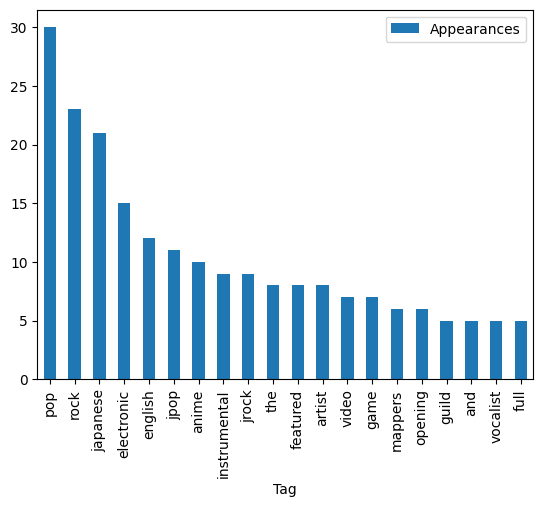

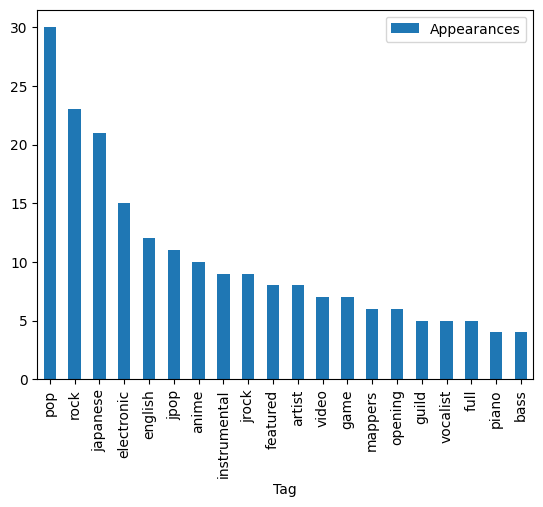

In [237]:
all_tags_sorted_table.head(20).plot.bar(x='Tag', y='Appearances') # Tale ne dela
tags_sorted_filtered.head(20).plot.bar(x='Tag', y='Appearances')

<AxesSubplot: xlabel='title'>

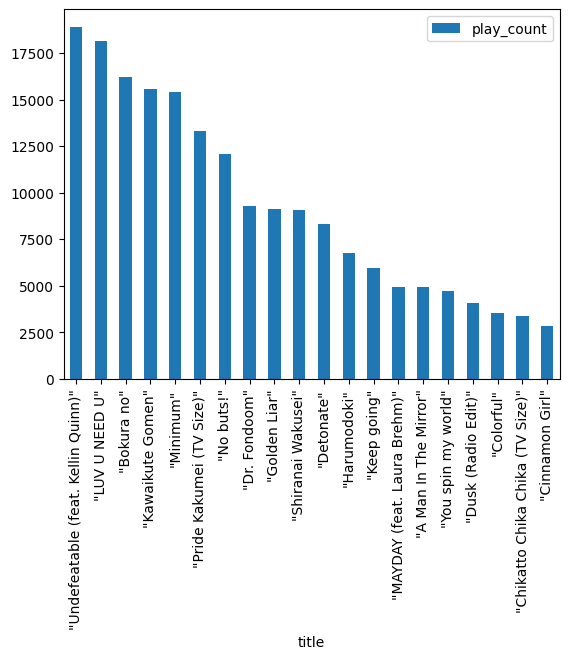

In [238]:
subtable_by_playcount = df[['id', 'title', 'play_count']].sort_values('play_count', ascending=False)
subtable_by_playcount.head(20).plot.bar(x='title', y='play_count')

## Bayes classificator goes here: predicting passcount for separate beatmaps given difficulty and playcount

_Additional note:_ This could be slightly problematic because lots of people are downloading the maps and just not playing them, + the difficulty is calculated based on a different classificator than just percentile

In [239]:
# beatmaps_ranked_by_playcount = subtable_by_playcount.reset_index().drop('index', axis= 1)
def grab_index_from_title(df: pd.DataFrame, title: str):
    for item in df.iterrows():
        if title in item[1][1]:
            return item[0]
def predict_passcount(df: pd.DataFrame, title: str):
    i = grab_index_from_title(df, title)
    beatmapset = df.iloc[i].beatmapset
grab_index_from_title(subtable_by_playcount, '"Bonetrousle"')

### This next one is of ***FIGURATIVE*** nature, caution is advised

Run this snippet only if you want to _spawn satan himself onto this world_, otherwise it's unnecessary

In [240]:
%%script false --no-raise-error
figure1, ax1 = plt.subplots()
ax1.pie(all_tags_sorted_table.Appearances, labels=all_tags_sorted_table.Tag, autopct='%1.1f%%', shadow=False, startangle=0)
ax1.axis('equal')
plt.title('The Antichrist')
#i'm submitting  this one just because of how cursed it is head(20)
plt.show()

### Random stuff

In [241]:
tags_sorted_filtered

,Tag,Appearances
0,pop,30
1,rock,23
2,japanese,21
3,electronic,15
4,english,12
...,...,...
599,gami,1
600,gang,1
601,ralsei,1
602,hewwo,1


In [242]:
for item in subtable_by_playcount.head(20).iterrows():
    print(item[1][1])
list(subtable_by_playcount.head(20).index)

"Undefeatable (feat. Kellin Quinn)"
"LUV U NEED U"
"Bokura no"
"Kawaikute Gomen"
"Minimum"
"Pride Kakumei (TV Size)"
"No buts!"
"Dr. Fondoom"
"Golden Liar"
"Shiranai Wakusei"
"Detonate"
"Harumodoki"
"Keep going"
"MAYDAY (feat. Laura Brehm)"
"A Man In The Mirror"
"You spin my world"
"Dusk (Radio Edit)"
"Colorful"
"Chikatto Chika Chika (TV Size)"
"Cinnamon Girl"


[24, 36, 39, 12, 29, 18, 20, 41, 35, 38, 31, 15, 33, 34, 19, 32, 22, 5, 16, 25]

In [275]:
df1 = pd.read_json('data.json')
a = 4
df1.beatmapset[a][0]

{'difficulty_rating': '5',
 'id': '3541769',
 'map_len': '132',
 'accuracy': '6',
 'approach_rate': '5',
 'beatmap_bpm': '174',
 'passcount': '39',
 'playcount': '196',
 'max_combo': '849'}

In [276]:
from math import sqrt
int(sqrt((float(df1.beatmapset[a][0]['difficulty_rating']) * 0.5 - 1)) / 10 * float(df1.beatmapset[a][0]['playcount'])) #the -1 could indicate starting at difficulty one, where 50% of players pass

24

In [277]:
int(df1.beatmapset[a][0]['passcount'])

39

## PLAN

Take beatmap -> scan through its tags -> based on how many tags the map has from the top say 20 tags make percent on how many players play each map -> for each beatmap in beatmap set take the percentage * difficulty to predict passcount -> sum for total predicted passcount -> sum over whole beatmap set for beatmap for actual passcount -> compare